# Day 16: Ticket Translation

https://adventofcode.com/2020/day/16

In [1]:
# Can I simplfy this? I'm sure there's a way to inline the string->int loop, but for now this works...

def readInput(filename):
    with open(filename) as f:
        blocks = [ f.split("\n") for f in [ b for b in f.read().split("\n\n") ] ]
    rulenames = []
    rules = {}
    for b in blocks[0]:
        r = b.split(": ")[0]
        l = [ i.split("-") for i in b.split(": ")[1].split(" or ") ]
        r0 = []
        for i in l:
            f0 = []
            for ii in i:
                f0.append(int(ii))
            r0.append(f0)
        rules[r] = r0
        rulenames.append(r)
    myticket = [ int(n) for n in blocks[1][1].split(",") ]
    tt = [b.split(",") for b in blocks[2][1:-1]]
    tickets = []
    for t in tt:
        tickets.append([ int(i) for i in t ])
    return rulenames,rules,myticket,tickets

In [2]:
rulenames,rules,myticket,tickets = readInput("data/day16test0.txt")
print(rulenames)
print(rules)
print(myticket)
print(tickets)

['class', 'row', 'seat']
{'class': [[1, 3], [5, 7]], 'row': [[6, 11], [33, 44]], 'seat': [[13, 40], [45, 50]]}
[7, 1, 14]
[[7, 3, 47], [40, 4, 50], [55, 2, 20], [38, 6, 12]]


## Part 1

In [3]:
import numpy as np

def checkRule(n,r):
    return r[0][0] <= n <= r[0][1] or r[1][0] <= n <= r[1][1]

def checkTicket(t,rules):
    vt = 0
    for n in t:
        vr = False
        for r in rules.keys():
            if checkRule(n,rules[r]):
                vr = True
                break
        if not vr:
            return False, n
        else:
            vt += 1
            continue
    return True, -1
            
def checkTickets(tickets,rules):
    val = []
    failn = []
    for t in tickets:
        v,n = checkTicket(t,rules)
        val.append(v)
        failn.append(n)
    fn = np.array(failn)
    return fn[fn>-1].sum(), val, failn

In [4]:
rulenames,rules,myticket,tickets = readInput("data/input16.txt")
result,val,failn = checkTickets(tickets,rules)
print("Solution Part 1 =",result)

Solution Part 1 = 25916


## Part 2

In [5]:
# Part 2 example, all tickets are valid, use for testing...
#rulenames,rules,myticket,tickets = readInput("data/day16test1.txt")
#result,val,failn = checkTickets(tickets,rules)

In [6]:
from itertools import compress

rulenames,rules,myticket,tickets = readInput("data/input16.txt")
result,val,failn = checkTickets(tickets,rules)
tickets = list(compress(tickets,val)) # Filter invalid tickets

#print(len(tickets),len(tickets[0]),len(rules))

In [7]:
# Compute 3D matrix N_tickets x N_numbers x N_rules of rule compliances 

resall = []
for t in tickets:
    rest = []
    for n in t:
        resn = []
        for r in rules.keys():
            resn.append(checkRule(n,rules[r]))
        rest.append(resn)
    resall.append(rest)
    
# Now make the AND of rule compliances of a given number in all tickets
# This should return a matrix N_numbers x N_rules

resand = np.ones((len(tickets[0]),len(rules.keys())),dtype=bool)
for jn in range(len(tickets[0])):
    for jr in range(len(rules.keys())):
        rand = resand[jn][jr]
        for rt in resall:
            rand = rand and rt[jn][jr]
        resand[jn][jr] = rand

# Ideally, at least one member of this matrix (e.g. one number) would satisfy only one rule,
# otherwise it'd be unsolvable...

# Note after the implementation of the code above: checked, there's one, and only one! Good!
# Below the code to check, not needed for final solution

#unique = [ n.sum() for n in resand ]
#print(unique)

# The one number that satisfy one rule only allows to "replace" (e.g. remove) the multiple compliance 
# results from other numbers, by removing that rule that was uniquely associated by "masking" the list. 
# Then rince and repeat with the next number that after masking now satifies only one rule, until each 
# line of the matrix only points to one colum (one single "True" per row)

passed = []

while True:
    unique = [ n.sum() for n in resand ]
    uu = [i for i, e in enumerate(unique) if e == 1]
    for u in uu:
        if u in passed:
            continue
        else:
            mask = resand[u]
            for i in range(len(resand)):
                if i==u:
                    continue
                else:
                    b = resand[i]
                    masked = [ bb and not mm for bb,mm in zip(b,mask)]
                    resand[i] = masked
            passed.append(u)
    if len(passed) == len(resand):
        break
        
#print(resand)

In [8]:
# All numbers are now mapped to a rule! Use map to find solution

prod = 1

for n,line in zip(myticket,resand):
    ri = [i for i, e in enumerate(line) if e == True]
    #print(n,line,ri[0],rulenames[ri[0]])
    #print(rulenames[ri[0]],"=",n)
    if rulenames[ri[0]][0:9] == "departure":
        print(f'{rulenames[ri[0]]:<18} =',n)
        prod *= n

print("\nSolution Part 2 =",prod)

departure date     = 179
departure platform = 101
departure track    = 107
departure time     = 211
departure station  = 61
departure location = 103

Solution Part 2 = 2564529489989


<ipython-input-53-cd83c7083c8b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(rulenames)


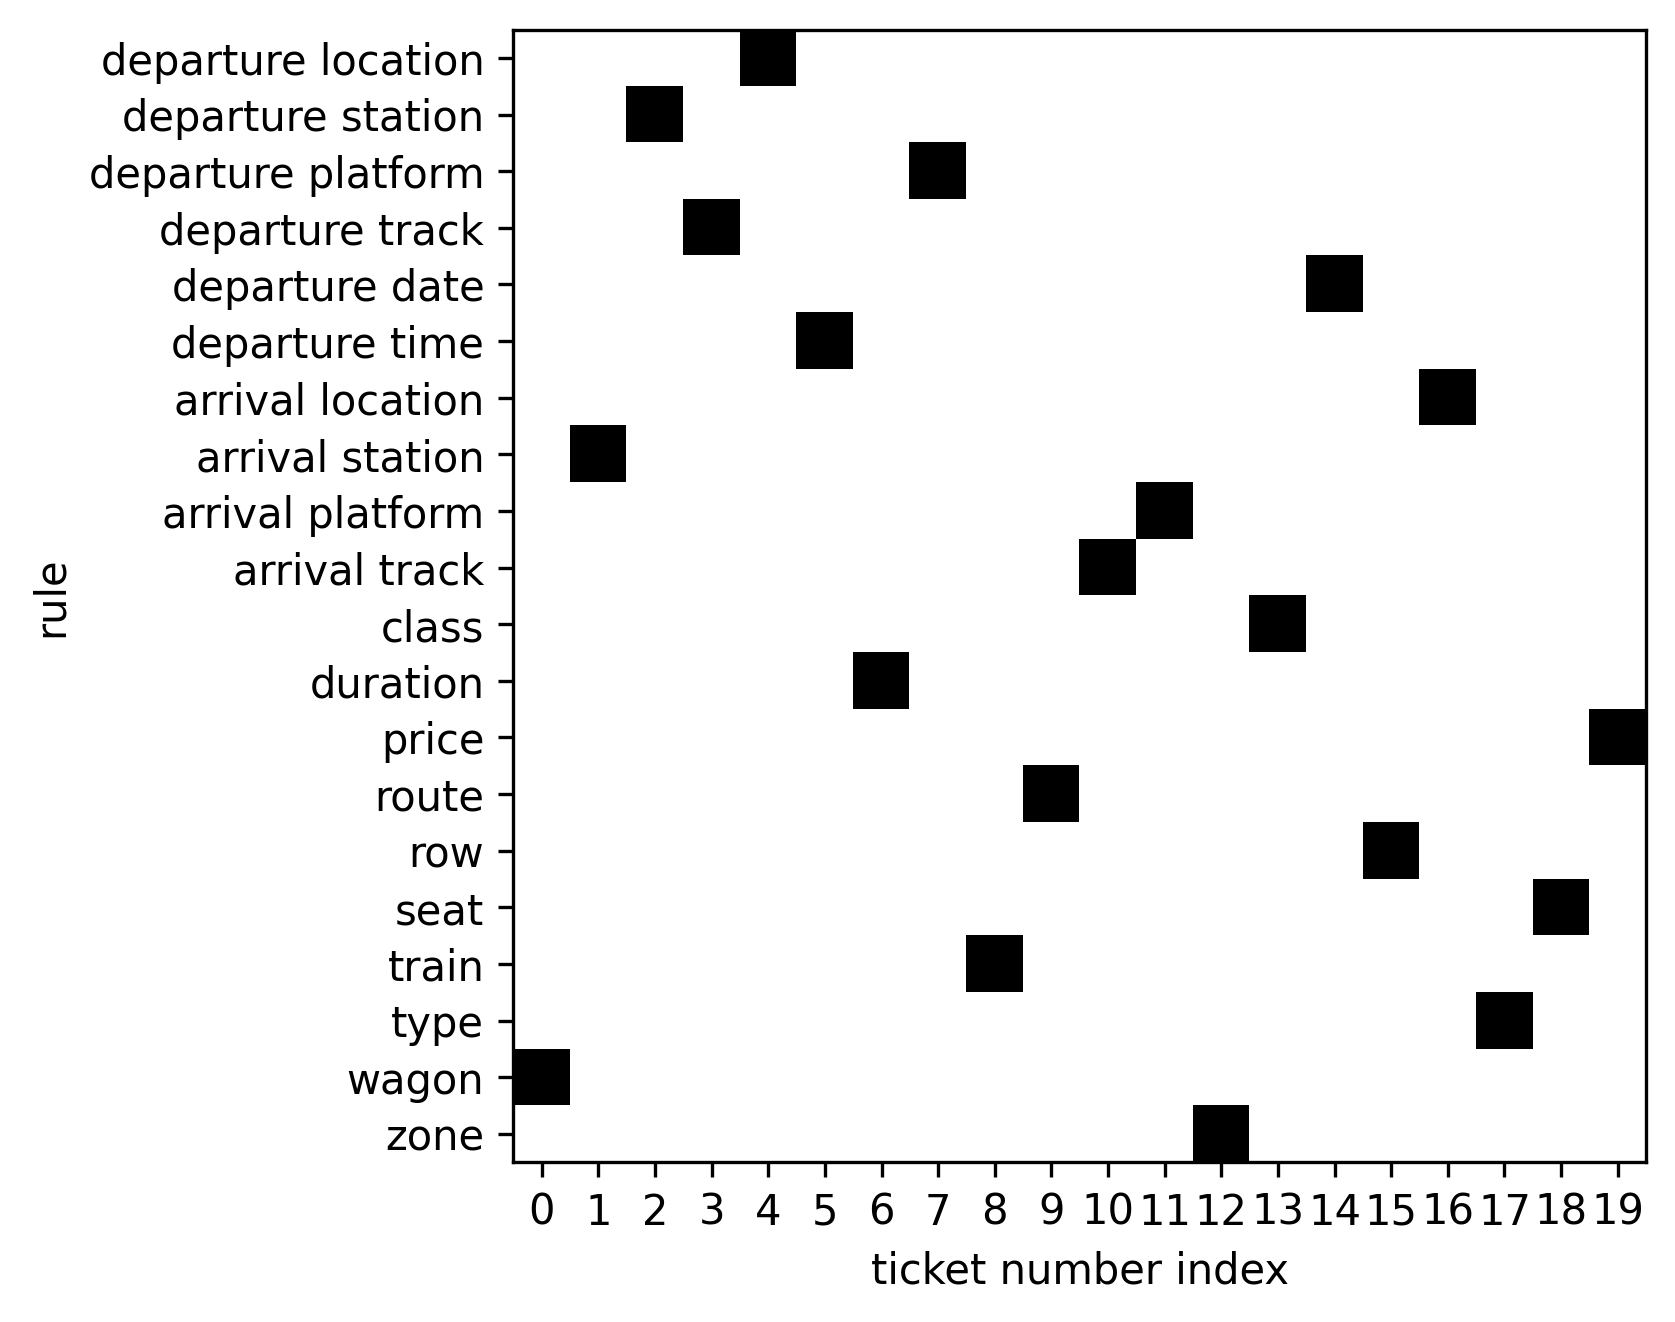

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5),dpi=300)
ax.set_yticklabels(rulenames)
plt.yticks(range(len(rulenames)))
plt.xticks(range(len(myticket)))
im = ax.imshow(resand,cmap="binary")
ax.set_xlabel('ticket number index')
ax.set_ylabel('rule')

plt.show()